# Total Pressure Inlet Condition 

In [168]:
using Ferrite
using SparseArrays
using LinearAlgebra 
using UnPack 
using OrdinaryDiffEq
using DifferentialEquations
using WriteVTK
using Plots 
using Printf
using Logging 

In [169]:
?generate_grid

search: generate_grid @generated Base.Generator



```
generate_grid(celltype::Cell, nel::NTuple, [left::Vec, right::Vec)
```

Return a `Grid` for a rectangle in 1, 2 or 3 dimensions. `celltype` defined the type of cells, e.g. `Triangle` or `Hexahedron`. `nel` is a tuple of the number of elements in each direction. `left` and `right` are optional endpoints of the domain. Defaults to -1 and 1 in all directions.


## Section 1: Introduction 

The <b>total pressure inlet condition</b> imposes that on the inlet patch $p_{total} = p_{static} + p_{dynamic}$. We recall that only total quantities are conserved. The condition implies that 
$p_{total} = p_{static} + 0.5 \, \rho \, \vec{v} \cdot \vec{v}$, where $p_{static}$ is the pressure solved for in the Navier-Stokes model. Physically speaking, we have that 

<b>Initial Pressure Difference</b>: If the inlet pressure (total pressure) is higher than the initial pressure inside the vessel, fluid flows into the vessel, increasing the internal pressure. This flow is driven by the pressure gradient between the inlet and the pressure inside the reservoir.
What happens next:

<b>Pressure Equilibration</b>: As fluid enters the closed vessel, the inner static pressure rises. For incompressible flow (or compressible flow within a rigid reservoir), the pressure increase is directly related to the added mass. For compressible fluids, density changes also contribute to pressure buildup and must be taken into account.

<b>Dynamic to Static Pressure Transition</b>: The inlet's total pressure includes static and dynamic components. As the vessel's internal static pressure approaches the inlet's total pressure, the dynamic pressure (velocity-dependent term) diminishes, slowing the flow.

<b>Steady-State Condition</b>: When the vessel's static pressure equals the inlet's total pressure, the pressure gradient driving the flow vanishes. At this point, the inflow velocity reduces to zero, and the system reaches a steady state with no net flow. See also, [this video](https://www.youtube.com/watch?v=Er2j5Kq17as)

The total pressure inlet condition is standard in various packages. These include 
[Fluent Users Guide](https://www.afs.enea.it/project/neptunius/docs/fluent/html/ug/node239.htm) and [OpenFoam Example](https://doc.openfoam.com/2306/tools/processing/boundary-conditions/rtm/derived/inletOutlet/totalPressure/). In this notebook we explore the implementation of this non-linear boundary condition is an existing FEM solver.   

## Section 2: Linear Scalar Diffusion  

### 2.1: Model Problem Formulation

**The Poisson Equation**

$$-\nabla^2 u(\mathbf{x}) = f(\mathbf{x}) \quad \text{on } \Omega$$

Where:
* $\mathbf{x}$ represents the spatial coordinates $(x, y)$ in our 2D case.
* $\nabla^2$ is the Laplacian operator, defined as $\frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}$. It describes the diffusion or distribution of $u$.
* $f(\mathbf{x})=1$ is a constant source term applied throughout the domain.


**The Domain and Boundary Conditions (BCs)**

Our computational domain $\Omega$ is a 2D rectangle. To solve the Poisson equation, we must specify boundary conditions (BCs) on the boundary $\partial \Omega$ of this domain. The provided code implements the following conditions:

1.  **Dirichlet BC**

    While the code specifically sets a condition on the "left" side, for a scalar diffusion problem like the Poisson equation, the other boundaries often implicitly have Neumann (zero-flux) boundary conditions if no other BCs are explicitly defined. This means no quantity is entering or leaving through these boundaries by diffusion.

    Using a Dirichlet boundary condition (such as $u=10.0$ on `left_patch`) is sufficient to make the Poisson problem non-singular and guarantee a unique solution for $u$.

    $$u(\mathbf{\text{left patch}}) = 10.0$$

2.  **Mean Average Constraint**

Dirichlet homogeneous conditions on three sides (top, bottom, right) fix the value of $u$ to zero, preventing trivial solutions.

Instead of fixing a point value, we impose a *mean* value on the remaining left boundary. This provides the necessary "anchor" for the solution, determining the overall level of $u$ on that specific boundary without strictly fixing every point. This is often more physically realistic in certain scenarios than a uniform Dirichlet condition.
    $$\frac{1}{L_{\text{left}}} \int_{\text{left boundary}} u \, ds = 10.0$$

This combination avoids the singularity issues that arise from imposing Neumann conditions on all boundaries (solution unique up to a constant) or Dirichlet homogeneous on all boundaries (trivial solution $u=0$).

3. **Penalty Method**

For the linear constraints using the [penalty method](https://en.wikipedia.org/wiki/Penalty_method), it suffices to add a boundary term to the weak form. More specifically, one adds to the weak form the weighting factor. The weighting factor p is initially zero and increases (to give more weight to the constraint to be imposed) as convergence is obtained. 

For the implementation of integrals over the boundary, the incompressible elasticity tutorial provides a good example. Look for the comment “We integrate the Neumann boundary using the FacetValues.” This part of the weak form needs to be updated with time. This is similar to the update of the non-linear part of the Jacobian in the incompressible Navier-Stokes tutorial. 

4. **Lagrange Multipliers**

For the linear constraints using this time Lagrange multipliers (as opposed to AffineConstraints that Ferrite already provides), I would need to look into the details. (For now, see [Lagrangian multipliers](https://en.wikipedia.org/wiki/Lagrange_multiplier). 

### 2.2: Numerical Solution

##### 2.2.1 Dirichlet and Mean Average Constraint

In [189]:
nelem_z = 100
nelem_y = 50
nels  = (nelem_z, nelem_y) # number of elements in each spatial direction
grid = generate_grid(Quadrilateral, nels);

ip  = Lagrange{RefQuadrilateral, 1}()
qr  = QuadratureRule{RefQuadrilateral}(2)
ipg = Lagrange{RefQuadrilateral,1}() # linear geometric interpolation
cvu = CellValues(qr, ip);
qr_facet = FacetQuadratureRule{RefQuadrilateral}(2)
fvu      = FacetValues(qr_facet, ip, ipg) # required for inlet integral constraint 

dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh);

ch = ConstraintHandler(dh);

In [190]:
function assemble_K!(K::SparseMatrixCSC, f::Vector, cellvalues::CellValues, dh::DofHandler)

    n_basefuncs = getnbasefunctions(cellvalues)
    Ke = zeros(n_basefuncs, n_basefuncs)
    fe = zeros(n_basefuncs)

    assembler = start_assemble(K, f)

    for cell in CellIterator(dh)

        fill!(Ke, 0)
        fill!(fe, 0)

        Ferrite.reinit!(cellvalues, cell)

        for q_point in 1:getnquadpoints(cellvalues)
            dΩ = getdetJdV(cellvalues, q_point)

            for i in 1:n_basefuncs
                v = shape_value(cellvalues, q_point, i)
                ∇v = shape_gradient(cellvalues, q_point, i)
                fe[i] += v * dΩ
                #fe[i] += 0 ---------------------------------------------------------
                for j in 1:n_basefuncs
                    ∇u = shape_gradient(cellvalues, q_point, j)
                    Ke[i, j] += (∇v ⋅ ∇u) * dΩ
                end
            end
        end

        assemble!(assembler, celldofs(cell), Ke, fe)
    end
    return K, f
end

assemble_K! (generic function with 1 method)

In [191]:
function setup_mean_constraint(dh, fvu)
    assembler = Ferrite.COOAssembler()
    # All external boundaries
    set = union(getfacetset(dh.grid, "left"))
    # Allocate buffers
    range_u = dof_range(dh, :u)
    element_dofs = zeros(Int, ndofs_per_cell(dh))
    element_dofs_u = view(element_dofs, range_u)
    element_coords = zeros(Vec{2}, 4) # assuming 2D mesh with quadrilaterals only
    Ce = zeros(1, length(range_u)) # Local constraint matrix (only 1 row)
    # Loop over all the boundaries
    for (ci, fi) in set
        Ce .= 0
        getcoordinates!(element_coords, dh.grid, ci)
        Ferrite.reinit!(fvu, element_coords, fi)
        celldofs!(element_dofs, dh, ci)
        for qp in 1:getnquadpoints(fvu)
            dΓ = getdetJdV(cvu, qp)
            for i in 1:getnbasefunctions(fvu)
                Ce[1, i] += shape_value(fvu, qp, i) * dΓ
            end
        end
        # Assemble to row 1
        assemble!(assembler, [1], element_dofs_u, Ce)
    end
    C, _ = finish_assemble(assembler)
    # Create an AffineConstraint from the C-matrix
    _, J, V = findnz(C)
    _, constrained_dof_idx = findmax(abs2, V)
    constrained_dof = J[constrained_dof_idx]
    V ./= V[constrained_dof_idx]
    mean_value_constraint = AffineConstraint(
        constrained_dof,
        Pair{Int, Float64}[J[i] => -V[i] for i in 1:length(J) if J[i] != constrained_dof],
        10.0,
    )
    return mean_value_constraint
end

setup_mean_constraint (generic function with 1 method)

In [192]:
function mypostprocess(u, dh, cvu, nels)

    numcells = nels[1]*nels[2]
    myu  = zeros(numcells)

    for (cell_num, cell) in enumerate(CellIterator(dh))

        Ferrite.reinit!(cvu, cell)
        
        dof_range_u = dof_range(dh,:u)
        uloc = u[celldofs(dh,cell_num)[dof_range_u]]
        Ferrite.reinit!(cvu, cell)

        cell_integral_u = 0.0 #  ceci est l'intégrale de u sur la cellule
        cell_physical_area = 0.0 # ceci est l'aire physique de la cellule
        
        for q_point in 1:getnquadpoints(cvu)
            dΩ = getdetJdV(cvu, q_point) # dΩ est le Jacobien * dV_ref (élément de volume différentiel)
            cell_u_at_qpoint = function_value(cvu, q_point, uloc) # Valeur de u au point de quadrature
            
            cell_physical_area += dΩ  # Accumule les éléments de volume différentiels pour l'aire totale de la cellule
            cell_integral_u += cell_u_at_qpoint * dΩ # Accumule l'intégrale de u sur la cellule
        end

        myu[cell_num]  = cell_integral_u / cell_physical_area 
        
    end  

    myu2d = reshape(myu, nels[1], nels[2])
    
    return nothing, myu2d
end

mypostprocess (generic function with 1 method)

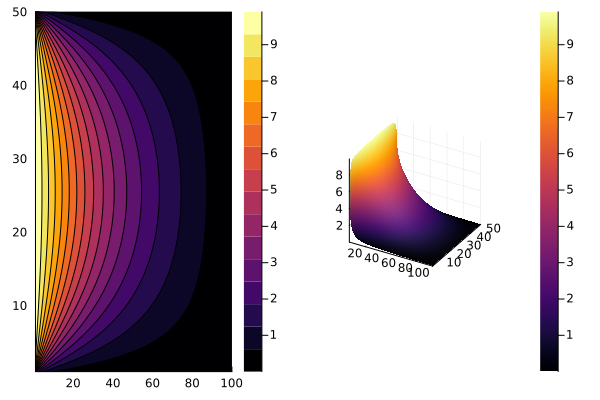

In [193]:
# Boundary conditions part: Dirichlet BC for the velocity at the top lid 
left_patch = getfacetset(dh.grid, "left")
if (true) # --------------------------------------------------------------------------------
    dbc1 = Dirichlet(:u, left_patch, (x,t) ->  10. )
else 
    dbc1 = setup_mean_constraint(dh, fvu)
end 

add!(ch, dbc1)

# Add Homogeneous Dirichlet Boundary conditions ---------------------------------------------
top_patch = getfacetset(dh.grid, "top")
bottom_patch = getfacetset(dh.grid, "bottom")
right_patch = getfacetset(dh.grid, "right")

# Create Dirichlet BCs for u=0 on these patches
dbc_top = Dirichlet(:u, top_patch, (x,t) -> 0.0)
dbc_bottom = Dirichlet(:u, bottom_patch, (x,t) -> 0.0)
dbc_right = Dirichlet(:u, right_patch, (x,t) -> 0.0)

# Add these new Dirichlet BCs to the ConstraintHandler
add!(ch, dbc_top)
add!(ch, dbc_bottom)
add!(ch, dbc_right)

close!(ch);

K = allocate_matrix(dh,ch);
M = allocate_matrix(dh,ch);
f = zeros(ndofs(dh));

K, f = assemble_K!(K, f, cvu, dh);
apply!(K, f, ch)
u = K \ f;

VTKGridFile("diffusion", dh) do vtk
    write_solution(vtk, dh, u)
    Ferrite.write_constraints(vtk, ch)
end

area, myu2d = mypostprocess(u, dh, cvu, nels)
p1 = contour(myu2d', fill=true)
p2 = surface(myu2d', fill=true)
plot(p1,p2, layout=(1,2))

##### 2.2.2 Penalty Method

In [194]:
nelem_z = 100
nelem_y = 50
nels  = (nelem_z, nelem_y) # number of elements in each spatial direction
grid = generate_grid(Quadrilateral, nels);

ip  = Lagrange{RefQuadrilateral, 1}()
qr  = QuadratureRule{RefQuadrilateral}(2)
ipg = Lagrange{RefQuadrilateral,1}() # linear geometric interpolation
cvu = CellValues(qr, ip);
qr_facet = FacetQuadratureRule{RefQuadrilateral}(2)
fvu      = FacetValues(qr_facet, ip, ipg) # required for inlet integral constraint 

dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh);

ch = ConstraintHandler(dh);

function assemble_K_and_f_with_penalty!(K::SparseMatrixCSC, f::Vector, cellvalues::CellValues, facetvalues::FacetValues, dh::DofHandler, left_patch_cells_faces, p_penalty::Float64)
    n_basefuncs = getnbasefunctions(cellvalues)
    Ke = zeros(n_basefuncs, n_basefuncs) # Element stiffness matrix
    fe = zeros(n_basefuncs)             # Element force vector

    assembler = start_assemble(K, f) # Initializes/resets K and f for assembly

    for cell in CellIterator(dh)

        fill!(Ke, 0.0) # Ensure elemental matrices are zeroed for each cell
        fill!(fe, 0.0)

        Ferrite.reinit!(cellvalues, cell) # Reinitialize cellvalues for the current cell

        # --- Domain integration (diffusion and source term) ---
        for q_point in 1:getnquadpoints(cellvalues)
            dΩ = getdetJdV(cellvalues, q_point) # Differential volume element

            f_val = 1.0 # Source term f (e.g., constant heat source)

            for i in 1:n_basefuncs
                v = shape_value(cellvalues, q_point, i)      # Shape function phi_i
                ∇v = shape_gradient(cellvalues, q_point, i) # Gradient of shape function phi_i
                
                # Contribution to elemental force vector (fe) from source term (f*v)
                fe[i] += f_val * v * dΩ
                
                for j in 1:n_basefuncs
                    ∇u = shape_gradient(cellvalues, q_point, j) # Gradient of shape function phi_j
                    # Contribution to elemental stiffness matrix (Ke) from diffusion term (∇v ⋅ ∇u)
                    Ke[i, j] += (∇v ⋅ ∇u) * dΩ
                end
            end
        end

        # --- Boundary integration (penalty term for left_patch) ---
        # This loop checks each facet of the current cell
        for face in 1:nfacets(cell)
            # If the current facet belongs to the 'left_patch' (where we apply penalty)
            if (cellid(cell), face) ∈ left_patch_cells_faces 
                
                Ferrite.reinit!(facetvalues, cell, face) # Reinitialize facetvalues for this specific facet
                
                for q_point_facet in 1:getnquadpoints(facetvalues)
                    dΓ = getdetJdV(facetvalues, q_point_facet) # Differential surface element

                    u_target = 10.0 # The desired value for u on the left_patch (Dirichlet value)

                    for i in 1:n_basefuncs
                        v_i = shape_value(facetvalues, q_point_facet, i) # Shape function phi_i
                        
                        # Contribution to elemental force vector (fe) from penalty: p_penalty * u_target * v_i
                        # This term pulls the solution towards u_target
                        fe[i] += p_penalty * u_target * v_i * dΓ

                        for j in 1:n_basefuncs
                            u_j = shape_value(facetvalues, q_point_facet, j) # Shape function phi_j
                            # Contribution to elemental stiffness matrix (Ke) from penalty: p_penalty * v_i * u_j
                            # This term represents the stiffness of the "penalty spring"
                            Ke[i, j] += p_penalty * v_i * u_j * dΓ
                        end
                    end
                end
            end
        end
        
        # Assemble the elemental matrices (Ke) and vectors (fe) into the global K and f
        assemble!(assembler, celldofs(cell), Ke, fe)
    end
    return K, f
end

# Boundary conditions part: Dirichlet BC 
left_patch = getfacetset(dh.grid, "left")
top_patch = getfacetset(dh.grid, "top")
bottom_patch = getfacetset(dh.grid, "bottom")
right_patch = getfacetset(dh.grid, "right")

# Create Dirichlet BCs for u=0 on these patches
#dbc_left = Dirichlet(:u, left_patch, (x,t) ->  10. )
dbc_top = Dirichlet(:u, top_patch, (x,t) -> 0.0)
dbc_bottom = Dirichlet(:u, bottom_patch, (x,t) -> 0.0)
dbc_right = Dirichlet(:u, right_patch, (x,t) -> 0.0)

# Add these new Dirichlet BCs to the ConstraintHandler
#add!(ch, dbc_left)
add!(ch, dbc_top)
add!(ch, dbc_bottom)
add!(ch, dbc_right)

close!(ch);

# Penalty Loop and Solution Function ---
function solve_poisson_penalty(dh::DofHandler, ch::ConstraintHandler, cvu::CellValues, fvu::FacetValues, left_patch_cells_faces)
    ndofs_total = ndofs(dh)
    
    # Penalty parameters
    p_penalty_initial = 1.0e0    # Starting penalty factor
    p_penalty_max = 1.0e8        # Maximum penalty factor
    p_increase_factor = 10.0     # Factor to increase penalty by in each iteration
    num_penalty_iterations = 7   # Number of penalty iterations

    # Initialize solution vector
    u_solution = zeros(ndofs_total) 

    current_p_penalty = p_penalty_initial
    
    # Outer loop for penalty parameter
    for penalty_iter in 1:num_penalty_iterations 
        @info "--- Penalty Iteration $(penalty_iter), p_penalty = $(current_p_penalty) ---"
        
        # Allocate global stiffness matrix K and force vector f for the current penalty iteration
        K = allocate_matrix(dh, ch); 
        f = zeros(ndofs_total);

        assemble_K_and_f_with_penalty!(K, f, cvu, fvu, dh, left_patch_cells_faces, current_p_penalty)

        # Apply explicit Dirichlet boundary conditions (top, bottom, right)
        Ferrite.apply!(K, f, ch) 
        
        # Solve the linear system for the current penalty value
        u_solution = K \ f;
        
        @info "  System solved for p_penalty = $(current_p_penalty)"

        # Prepare for the next penalty iteration by increasing the penalty parameter
        current_p_penalty *= p_increase_factor
        # Cap the penalty parameter at p_penalty_max to prevent numerical issues with excessively large values
        if current_p_penalty > p_penalty_max
            current_p_penalty = p_penalty_max
        end
    end
    
    return u_solution # Return the final solution after all penalty iterations
end

penalty_u = solve_poisson_penalty(dh, ch, cvu, fvu, left_patch);


[ Info: --- Penalty Iteration 1, p_penalty = 1.0 ---
[ Info:   System solved for p_penalty = 1.0
[ Info: --- Penalty Iteration 2, p_penalty = 10.0 ---
[ Info:   System solved for p_penalty = 10.0
[ Info: --- Penalty Iteration 3, p_penalty = 100.0 ---
[ Info:   System solved for p_penalty = 100.0
[ Info: --- Penalty Iteration 4, p_penalty = 1000.0 ---
[ Info:   System solved for p_penalty = 1000.0
[ Info: --- Penalty Iteration 5, p_penalty = 10000.0 ---
[ Info:   System solved for p_penalty = 10000.0
[ Info: --- Penalty Iteration 6, p_penalty = 100000.0 ---
[ Info:   System solved for p_penalty = 100000.0
[ Info: --- Penalty Iteration 7, p_penalty = 1.0e6 ---
[ Info:   System solved for p_penalty = 1.0e6


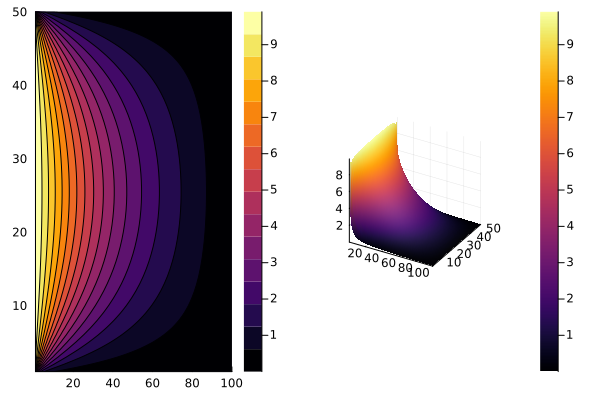

In [195]:
function mypostprocess(u, dh, cvu, nels)

    numcells = nels[1]*nels[2]
    myu  = zeros(numcells)

    for (cell_num, cell) in enumerate(CellIterator(dh))

        Ferrite.reinit!(cvu, cell)
        
        dof_range_u = dof_range(dh,:u)
        uloc = u[celldofs(dh,cell_num)[dof_range_u]]
        Ferrite.reinit!(cvu, cell)

        cell_integral_u = 0.0 #  ceci est l'intégrale de u sur la cellule
        cell_physical_area = 0.0 # ceci est l'aire physique de la cellule
        
        for q_point in 1:getnquadpoints(cvu)
            dΩ = getdetJdV(cvu, q_point) # dΩ est le Jacobien * dV_ref (élément de volume différentiel)
            cell_u_at_qpoint = function_value(cvu, q_point, uloc) # Valeur de u au point de quadrature
            
            cell_physical_area += dΩ  # Accumule les éléments de volume différentiels pour l'aire totale de la cellule
            cell_integral_u += cell_u_at_qpoint * dΩ # Accumule l'intégrale de u sur la cellule
        end

        myu[cell_num]  = cell_integral_u / cell_physical_area 
        
    end  

    myu2d = reshape(myu, nels[1], nels[2])
    
    return nothing, myu2d
end

area, myu2d = mypostprocess(penalty_u, dh, cvu, nels)
p1 = contour(myu2d', fill=true)
p2 = surface(myu2d', fill=true)
plot(p1,p2, layout=(1,2))


**Analysis of Penalty Method Convergence**

In [196]:
nelem_z = 100
nelem_y = 50
nels  = (nelem_z, nelem_y) # number of elements in each spatial direction
grid = generate_grid(Quadrilateral, nels);

ip  = Lagrange{RefQuadrilateral, 1}()
qr  = QuadratureRule{RefQuadrilateral}(2)
ipg = Lagrange{RefQuadrilateral,1}() # linear geometric interpolation
cvu = CellValues(qr, ip);
qr_facet = FacetQuadratureRule{RefQuadrilateral}(2)
fvu      = FacetValues(qr_facet, ip, ipg) # required for inlet integral constraint 

dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh);

ch = ConstraintHandler(dh);

function assemble_K_and_f_with_penalty!(K::SparseMatrixCSC, f::Vector, cellvalues::CellValues, facetvalues::FacetValues, dh::DofHandler, left_patch_cells_faces, p_penalty::Float64)
    n_basefuncs = getnbasefunctions(cellvalues)
    Ke = zeros(n_basefuncs, n_basefuncs) # Element stiffness matrix
    fe = zeros(n_basefuncs)             # Element force vector

    assembler = start_assemble(K, f) # Initializes/resets K and f for assembly

    for cell in CellIterator(dh)

        fill!(Ke, 0.0) # Ensure elemental matrices are zeroed for each cell
        fill!(fe, 0.0)

        Ferrite.reinit!(cellvalues, cell) # Reinitialize cellvalues for the current cell

        # --- Domain integration (diffusion and source term) ---
        for q_point in 1:getnquadpoints(cellvalues)
            dΩ = getdetJdV(cellvalues, q_point) # Differential volume element

            f_val = 1.0 # Source term f (e.g., constant heat source)

            for i in 1:n_basefuncs
                v = shape_value(cellvalues, q_point, i)      # Shape function phi_i
                ∇v = shape_gradient(cellvalues, q_point, i) # Gradient of shape function phi_i
                
                # Contribution to elemental force vector (fe) from source term (f*v)
                fe[i] += f_val * v * dΩ
                
                for j in 1:n_basefuncs
                    ∇u = shape_gradient(cellvalues, q_point, j) # Gradient of shape function phi_j
                    # Contribution to elemental stiffness matrix (Ke) from diffusion term (∇v ⋅ ∇u)
                    Ke[i, j] += (∇v ⋅ ∇u) * dΩ
                end
            end
        end

        # --- Boundary integration (penalty term for left_patch) ---
        # This loop checks each facet of the current cell
        for face in 1:nfacets(cell)
            # If the current facet belongs to the 'left_patch' (where we apply penalty)
            if (cellid(cell), face) ∈ left_patch_cells_faces 
                
                Ferrite.reinit!(facetvalues, cell, face) # Reinitialize facetvalues for this specific facet
                
                for q_point_facet in 1:getnquadpoints(facetvalues)
                    dΓ = getdetJdV(facetvalues, q_point_facet) # Differential surface element

                    u_target = 10.0 # The desired value for u on the left_patch (Dirichlet value)

                    for i in 1:n_basefuncs
                        v_i = shape_value(facetvalues, q_point_facet, i) # Shape function phi_i
                        
                        # Contribution to elemental force vector (fe) from penalty: p_penalty * u_target * v_i
                        # This term pulls the solution towards u_target
                        fe[i] += p_penalty * u_target * v_i * dΓ

                        for j in 1:n_basefuncs
                            u_j = shape_value(facetvalues, q_point_facet, j) # Shape function phi_j
                            # Contribution to elemental stiffness matrix (Ke) from penalty: p_penalty * v_i * u_j
                            # This term represents the stiffness of the "penalty spring"
                            Ke[i, j] += p_penalty * v_i * u_j * dΓ
                        end
                    end
                end
            end
        end
        
        # Assemble the elemental matrices (Ke) and vectors (fe) into the global K and f
        assemble!(assembler, celldofs(cell), Ke, fe)
    end
    return K, f
end

# Boundary conditions part: Dirichlet BC 
left_patch = getfacetset(dh.grid, "left")
top_patch = getfacetset(dh.grid, "top")
bottom_patch = getfacetset(dh.grid, "bottom")
right_patch = getfacetset(dh.grid, "right")

# Create Dirichlet BCs for u=0 on these patches
#dbc_left = Dirichlet(:u, left_patch, (x,t) ->  10. )
dbc_top = Dirichlet(:u, top_patch, (x,t) -> 0.0)
dbc_bottom = Dirichlet(:u, bottom_patch, (x,t) -> 0.0)
dbc_right = Dirichlet(:u, right_patch, (x,t) -> 0.0)

# Add these new Dirichlet BCs to the ConstraintHandler
#add!(ch, dbc_left)
add!(ch, dbc_top)
add!(ch, dbc_bottom)
add!(ch, dbc_right)

close!(ch);

# Penalty Loop and Solution Function ---
function solve_poisson_penalty(dh::DofHandler, ch::ConstraintHandler, cvu::CellValues, fvu::FacetValues, left_patch_cells_faces)
    ndofs_total = ndofs(dh)
    
    p_penalty_initial = 1.0e0    # Starting penalty factor
    p_penalty_max = 1.0e8        # Maximum penalty factor
    p_increase_factor = 10.0     # Factor to increase penalty by in each iteration
    num_penalty_iterations = 7   # Number of penalty iterations

    u_solution = zeros(ndofs_total) 
    
    all_penalty_solutions = Vector{Tuple{Float64, Vector{Float64}}}() 

    current_p_penalty = p_penalty_initial
    
    for penalty_iter in 1:num_penalty_iterations 
        @info "--- Penalty Iteration $(penalty_iter), p_penalty = $(current_p_penalty) ---"
        
        K = allocate_matrix(dh, ch); 
        f = zeros(ndofs_total);

        assemble_K_and_f_with_penalty!(K, f, cvu, fvu, dh, left_patch_cells_faces, current_p_penalty)

        Ferrite.apply!(K, f, ch) 
        
        u_solution = K \ f;
        
        @info "  System solved for p_penalty = $(current_p_penalty)"

        push!(all_penalty_solutions, (current_p_penalty, copy(u_solution)))

        current_p_penalty *= p_increase_factor
        if current_p_penalty > p_penalty_max
            current_p_penalty = p_penalty_max
        end
    end
    
    return all_penalty_solutions # MODIFIÉ : Retourne toutes les solutions
end

all_solutions = solve_poisson_penalty(dh, ch, cvu, fvu, left_patch);

[ Info: --- Penalty Iteration 1, p_penalty = 1.0 ---
[ Info:   System solved for p_penalty = 1.0
[ Info: --- Penalty Iteration 2, p_penalty = 10.0 ---
[ Info:   System solved for p_penalty = 10.0
[ Info: --- Penalty Iteration 3, p_penalty = 100.0 ---
[ Info:   System solved for p_penalty = 100.0
[ Info: --- Penalty Iteration 4, p_penalty = 1000.0 ---
[ Info:   System solved for p_penalty = 1000.0
[ Info: --- Penalty Iteration 5, p_penalty = 10000.0 ---
[ Info:   System solved for p_penalty = 10000.0
[ Info: --- Penalty Iteration 6, p_penalty = 100000.0 ---
[ Info:   System solved for p_penalty = 100000.0
[ Info: --- Penalty Iteration 7, p_penalty = 1.0e6 ---
[ Info:   System solved for p_penalty = 1.0e6


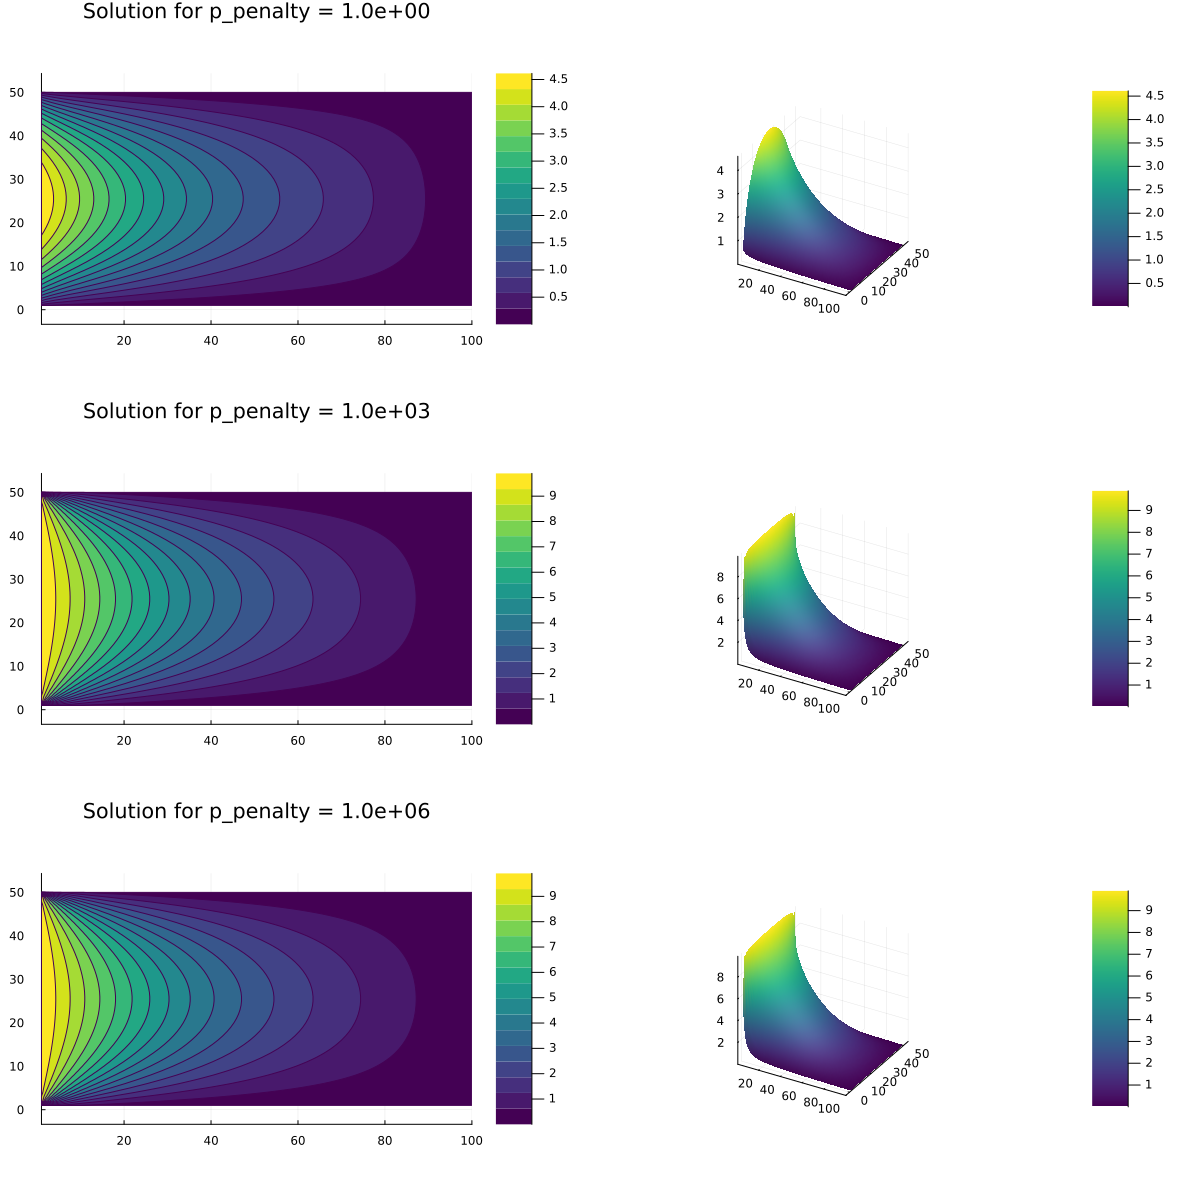

In [197]:
function mypostprocess(u, dh, cvu, nels)

    numcells = nels[1]*nels[2]
    myu  = zeros(numcells)

    for (cell_num, cell) in enumerate(CellIterator(dh))

        Ferrite.reinit!(cvu, cell)
        
        dof_range_u = dof_range(dh,:u)
        uloc = u[celldofs(dh,cell_num)[dof_range_u]]
        Ferrite.reinit!(cvu, cell)

        cell_integral_u = 0.0 #  ceci est l'intégrale de u sur la cellule
        cell_physical_area = 0.0 # ceci est l'aire physique de la cellule
        
        for q_point in 1:getnquadpoints(cvu)
            dΩ = getdetJdV(cvu, q_point) # dΩ est le Jacobien * dV_ref (élément de volume différentiel)
            cell_u_at_qpoint = function_value(cvu, q_point, uloc) # Valeur de u au point de quadrature
            
            cell_physical_area += dΩ  # Accumule les éléments de volume différentiels pour l'aire totale de la cellule
            cell_integral_u += cell_u_at_qpoint * dΩ # Accumule l'intégrale de u sur la cellule
        end

        myu[cell_num]  = cell_integral_u / cell_physical_area 
        
    end  

    myu2d = reshape(myu, nels[1], nels[2])
    
    return nothing, myu2d
end

indices_to_plot = [1, 4, 7] # Exemple pour : début, milieu et fin du ramping

# Créez une liste de plots pour les afficher ensemble
plots_collection = []

for idx in indices_to_plot
    p_val, u_sol = all_solutions[idx] # Récupère la valeur de p_penalty et la solution u
    
    # Post-traiter la solution pour ce p_penalty
    _, myu2d = mypostprocess(u_sol, dh, cvu, nels) # si mypostprocess retourne encore (area, myu2d)

    # Créer le titre du plot
    plot_title = "Solution for p_penalty = $(@sprintf("%.1e", p_val))" # Format scientifique pour p_penalty

    # Créer les plots de contour et surface pour cette solution
    p_contour = contour(myu2d', fill=true, title=plot_title, aspect_ratio=:equal, c=:viridis)
    p_surface = surface(myu2d', title="", aspect_ratio=:equal, c=:viridis) # Pas de titre pour la surface si on veut le titre principal sur le contour

    # Ajoutez les deux plots à la collection
    push!(plots_collection, p_contour)
    push!(plots_collection, p_surface)
end

# Affichez tous les plots dans une seule figure
final_plot = plot(plots_collection..., layout=(length(indices_to_plot), 2), size=(1200, 400 * length(indices_to_plot)))

display(final_plot) 

This visualization allows us to clearly observe the convergence behavior of the penalty method.

**Observations and Interpretation:**

1.  $p_{penalty} = 1.0 \times 10^0$ (Low Penalty Value)
    * Visuals: The contour plot shows values ranging from approximately $0$ to $4.5$ (indicated by the color bar). The solution is clearly highest near the left patch and gradually diffuses towards the other boundaries (where $u=0$ is imposed). The 3D surface plot shows a "hill" that peaks around $4.5$ on the left edge.
    * Interpretation: With a low penalty value ($1.0$), the Dirichlet boundary condition $u=10.0$ on the left patch is weakly enforced. The solution is not forced to reach $10.0$, but rather represents a compromise between the source term, the zero Dirichlet conditions, and the loose penalty constraint. The maximum value of $u \approx 4.5$ on the left edge demonstrates that the condition is only partially satisfied.

2.  $p_{penalty} = 1.0 \times 10^3$ (Medium Penalty Value)
    * Visuals: The color bar now ranges from approximately $0$ to $10.0$. The contour lines near the left patch are much denser and the color approaches yellow, indicating higher values. The 3D surface plot shows a significantly taller and steeper "wall" on the left edge, peaking at values close to $10.0$. The values in the rest of the domain still smoothly transition towards zero.
    * Interpretation: As the penalty increases to $1.0 \times 10^3$, the condition $u=10.0$ on the left patch is much more strongly enforced. The solution on the left edge is now very close to the target value of $10.0$. The system is "penalizing" deviations from $10.0$ much more severely, effectively pulling the solution towards the desired boundary value.

3.  $p_{penalty} = 1.0 \times 10^6$ (High Penalty Value)
    * Visuals: The color bar again ranges from approximately $0$ to $10.0$, appearing identical to the previous plot. Visually, the contour lines and the 3D surface plot are almost indistinguishable from those at $p_{penalty} = 1.0 \times 10^3$. The peak value on the left edge remains very close to $10.0$.
    * Interpretation: At this high penalty value, the boundary condition $u=10.0$ is effectively fully enforced within the limits of machine precision. The solution on the left edge has converged to a value extremely close to $10.0$. The fact that the visual appearance is almost identical to $p_{penalty} = 1.0 \times 10^3$ suggests that increasing the penalty further yields diminishing returns in accuracy, as the numerical error from the finite penalty value becomes negligible compared to other sources of error or the precision limits.

**Conclusion:**

These plots successfully demonstrate the convergence behavior of the penalty method. As the penalty parameter $p_{penalty}$ is increased:

* The solution $u(\mathbf{x})$ on the left boundary gradually approaches the target Dirichlet value of $10.0$.
* The influence of the boundary condition becomes stronger, forcing the solution to comply more accurately with the desired constraint.
* Beyond a certain point (around $1.0 \times 10^3$ in this case), further increases in $p_{penalty}$ lead to very little change in the solution, indicating that the penalty method has effectively converged to the strong enforcement of the boundary condition.

## Section 3: Non linear Scalar Diffusion  

### 3.1 Model Problem Formulation

**The Poisson Equation**

We are still solving the Poisson equation on our domain $\Omega$:

$$-\nabla^2 u(\mathbf{x}) = f(\mathbf{x}) \quad \text{on } \Omega$$

The constant source term $f(\mathbf{x})=1$ is applied throughout the domain.

We maintain homogeneous Dirichlet conditions ($u=0$) on the top, bottom, and right boundaries.

However, we are now implementing a non-linear Dirichlet boundary condition on the left patch :

$$u(\mathbf{\text{left patch}})^2 = 100$$

This non-linear condition makes the overall problem non-linear, requiring iterative solution methods.


### 3.2 Solution Approaches    

#### 3.2.1 : Transient Penalty Method 

For robustly solving our non-linear steady-state Poisson problem, a smart implementation is crucial.

We will achieve this by solving a transient form of the Poisson equation:

$$\frac{\partial u}{\partial t} - \nabla^2 u = f \quad \text{on } \Omega$$

Here, the non-linear Dirichlet condition $u(\mathbf{\text{left patch}})^2 = 100$ will be enforced using a penalty method. The key idea, as suggested, is to make the penalty parameter $p$ time-dependent, e.g., $p(t) = t$.

This leads to a weak formulation of the problem involving a time derivative and a time-dependent penalty term on the boundary:

$$\int_\Omega \frac{\partial u}{\partial t} v \, d\Omega + \int_\Omega \nabla u \cdot \nabla v \, d\Omega - \int_\Omega f v \, d\Omega + \int_{\text{left patch}} p(t) \cdot (u^2 - 100) \cdot u \cdot v \, d\Gamma = 0$$

This approach allows us to:

* Automate Parameter Ramping:The increase of the penalty parameter $p(t)=t$ is intrinsically handled by the time integration.
* Delegate Solution Process: We can leverage specialized ODE/DAE solvers (e.g., `DifferentialEquations.jl`) to manage the entire process, including the non-linear iterations (Newton's method) at each "time" step and the stable evolution of the solution as $p(t)$ increases.

This method effectively transforms the complex "inner-outer" iteration scheme (in which the outer iteration governs the value of the penalty parameter and in which the inner iteration solves a system of non-linear equations for a given value of the penalty parameter) into a single, solvable transient problem, greatly simplifying the implementation.


### 3.3 Numerical Solutions

#### 3.3.1 Transient Penalty Method for Non Linear BC

In [3]:
# grid = generate_grid(Quadrilateral, (100, 100));
nelem = 20 
nels  = (nelem, nelem) # number of elements in each spatial direction
grid = generate_grid(Quadrilateral, nels);

ip  = Lagrange{RefQuadrilateral, 1}()
qr  = QuadratureRule{RefQuadrilateral}(2)
ipg = Lagrange{RefQuadrilateral,1}() # linear geometric interpolation
cvu = CellValues(qr, ip);
qr_facet = FacetQuadratureRule{RefQuadrilateral}(2)
fvu      = FacetValues(qr_facet, ip, ipg) # required for inlet integral constraint 

dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh);

ch = ConstraintHandler(dh);

In [4]:
# This matrix corresponds to the ∂u/∂t term in the weak form: ∫ (∂u/∂t) v dΩ
function assemble_mass_matrix!(M::SparseMatrixCSC, cellvalues::CellValues, dh::DofHandler)
    n_basefuncs = getnbasefunctions(cellvalues)
    Me = zeros(n_basefuncs, n_basefuncs) 
    assembler = start_assemble(M)
    
    for cell in CellIterator(dh)
        fill!(Me, 0.0)
        Ferrite.reinit!(cellvalues, cell)

        for q_point in 1:getnquadpoints(cellvalues)
            dΩ = getdetJdV(cellvalues, q_point)
            for i in 1:n_basefuncs
                v_i = shape_value(cellvalues, q_point, i)
                for j in 1:n_basefuncs
                    u_j = shape_value(cellvalues, q_point, j)
                    Me[i, j] += v_i * u_j * dΩ # ∫ (phi_i * phi_j) dΩ
                end
            end
        end
        assemble!(assembler, celldofs(cell), Me)
    end
    return M
end

assemble_mass_matrix! (generic function with 1 method)

In [5]:
# Assemble Jacobian (J) and Residual (R) for the Spatial Part ---
# This function now calculates the non-linear spatial residual (R) and its Jacobian (J).
function assemble_jacobian_residual!(J::SparseMatrixCSC, R::Vector, cellvalues::CellValues, facetvalues::FacetValues, dh::DofHandler, u_current::Vector, left_patch_cells_faces, t::Float64)
                                                                                                                                                           
    n_basefuncs = getnbasefunctions(cellvalues)
    Je = zeros(n_basefuncs, n_basefuncs) 
    re = zeros(n_basefuncs)             

    assembler = start_assemble(J, R) 

    for cell in CellIterator(dh)

        fill!(Je, 0.0)
        fill!(re, 0.0)

        Ferrite.reinit!(cellvalues, cell)
        
        # Get the current solution values for the DOFs within this cell
        cell_u_current = u_current[celldofs(cell)]

        # --- Domain integration (diffusion and source term) ---
        for q_point in 1:getnquadpoints(cellvalues)
            dΩ = getdetJdV(cellvalues, q_point) 

            f_val = 1.0 # Source term f

            # Evaluate gradient of current solution at quadrature point
            ∇u_current_q = function_gradient(cellvalues, q_point, cell_u_current)

            for i in 1:n_basefuncs
                v = shape_value(cellvalues, q_point, i)      
                ∇v = shape_gradient(cellvalues, q_point, i) 
                
                # Contribution to elemental residual (re): ∇u_current ⋅ ∇v - f_val * v
                re[i] += (∇u_current_q ⋅ ∇v - f_val * v) * dΩ
                
                for j in 1:n_basefuncs
                    ∇u_j = shape_gradient(cellvalues, q_point, j) # Gradient of basis function phi_j
                    # Contribution to elemental Jacobian (Je) from diffusion term: (∇v ⋅ ∇u_j)
                    Je[i, j] += (∇v ⋅ ∇u_j) * dΩ
                end
            end
        end

        # --- Boundary integration (NON-LINEAR penalty term for left_patch) ---
        for face in 1:nfacets(cell)
            if FacetIndex(cellid(cell), face) ∈ left_patch
                
                Ferrite.reinit!(facetvalues, cell, face) 
                
                for q_point_facet in 1:getnquadpoints(facetvalues)
                    dΓ = getdetJdV(facetvalues, q_point_facet) 

                    # Current penalty parameter, which depends on time 't'
                    p_penalty = t
                    # p_penalty = max(1.0e-3, t) or p_penalty = t * 1.0e0 
                    
                    # Evaluate current solution 'u' at the facet quadrature point
                    u_q_current = function_value(facetvalues, q_point_facet, cell_u_current)

                    # Target value for the non-linear constraint (u^2 = 100 => u_target_squared = 100)
                    u_target_squared = 100.0 

                    for i in 1:n_basefuncs
                        v_i = shape_value(facetvalues, q_point_facet, i) 
                        
                        # Contribution to elemental residual (re) from penalty: p * (u^2 - u_target_squared) * v_i
                        re[i] += p_penalty * (u_q_current^2 - u_target_squared) * v_i * dΓ

                        for j in 1:n_basefuncs
                            u_j = shape_value(facetvalues, q_point_facet, j) # Basis function phi_j
                            # This is the derivative of the penalty residual w.r.t. u_j
                            Je[i, j] += p_penalty * 2.0 * u_q_current * v_i * u_j * dΓ
                        end
                    end
                end
            end
        end
        
        assemble!(assembler, celldofs(cell), Je, re)
    end
    return J, R
end


assemble_jacobian_residual! (generic function with 1 method)

In [6]:
# Boundary conditions part: Dirichlet BC 
left_patch = getfacetset(dh.grid, "left")
top_patch = getfacetset(dh.grid, "top")
bottom_patch = getfacetset(dh.grid, "bottom")
right_patch = getfacetset(dh.grid, "right")

# Create Dirichlet BCs for u=0 on these patches
#dbc_left = Dirichlet(:u, left_patch, (x,t) ->  10. )
dbc_top = Dirichlet(:u, top_patch, (x,t) -> 0.0)
dbc_bottom = Dirichlet(:u, bottom_patch, (x,t) -> 0.0)
dbc_right = Dirichlet(:u, right_patch, (x,t) -> 0.0)

# Add these new Dirichlet BCs to the ConstraintHandler
#add!(ch, dbc_left)
add!(ch, dbc_top)
add!(ch, dbc_bottom)
add!(ch, dbc_right)

close!(ch);

In [16]:
# ODE Function for DifferentialEquations.jl ---
# This function defines the right-hand side of M * du/dt = -R(u,t)
function ode_function!(dR, u, p_ode, t)
    # Extract parameters from p_ode tuple
    dh, ch, cvu, fvu, left_patch = p_ode

    # Allocate Jacobian and Residual vectors/matrices
    J = allocate_matrix(dh, ch) 
    R_spatial = zeros(ndofs(dh))
    
    # Assemble the Jacobian and Spatial Residual for the current u and t
    assemble_jacobian_residual!(J, R_spatial, cvu, fvu, dh, u, left_patch, t)

    # Apply explicit Dirichlet boundary conditions to J and R_spatial
    Ferrite.apply!(J, R_spatial, ch) 
    
    # The ODE problem is M * du/dt = -R_spatial
    dR .= -R_spatial # Fill the output vector dR
    return nothing
end

# Main function to solve the transient problem ---
function solve_transient_poisson_penalty(dh::DofHandler, ch::ConstraintHandler, cvu::CellValues, fvu::FacetValues, left_patch)
    
    ndofs_total = ndofs(dh)
    
    # Initial condition for u at t=0 (e.g., all zeros)
    u0 = zeros(ndofs_total) 

    # Time span for the transient simulation
    tspan = (0.0, 50.0) 

    # Parameters to pass to the ODE function (dh, ch, etc.)
    params = (dh, ch, cvu, fvu, left_patch)

    # Assemble the global mass matrix once (it's constant for this problem)
    M_global = assemble_mass_matrix!(allocate_matrix(dh, ch), cvu, dh)
    
    # This tells DifferentialEquations.jl that it's a MassMatrix problem (M * du/dt = f(u,t)).
    f_ode_prob = ODEFunction(ode_function!, mass_matrix=M_global)
    
    # Define the ODE problem using the ODEFunction
    ode_prob = ODEProblem(f_ode_prob, u0, tspan, params) 

    # Solve the ODE problem using an implicit solver 
    sol = solve(ode_prob, Rodas5(autodiff=AutoFiniteDiff()), reltol=1e-6, abstol=1e-8, progress=true, saveat=1.0) # <--- C'est la bonne ligne

    # Return the complete sol object
    return sol
end

sol_result = solve_transient_poisson_penalty(dh, ch, cvu, fvu, left_patch); #

# --- Post-processing and VTK export (pour tous les temps pour Paraview) ---
println("Saving transient solution to VTK files for Paraview...")

# Boucle sur tous les pas de temps enregistrés dans sol_result
for i in 1:length(sol_result.t)
    t_current = sol_result.t[i]
    u_current = sol_result.u[i] # La solution (vecteur de DOFs) au temps t_current

    # Nom de fichier unique pour chaque pas de temps
    filename = @sprintf("diffusion_penalty_transient_nonlinear_u_t%.2f.vtu", t_current)

    VTKGridFile(filename, dh) do vtk
        write_solution(vtk, dh, u_current)
    end
end

println("Transient VTK files saved. Open the first file (e.g., diffusion_penalty_transient_nonlinear_u_t0001.vtu) in Paraview and select 'Series' to animate!")

Saving transient solution to VTK files for Paraview...


LoadError: LoadError: UndefVarError: `@sprintf` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing Printf in the current active module Main
in expression starting at In[16]:63

Generating GIF...
GIF saved to transient_solution_penalty.gif


[ Info: Saved animation to C:\Users\anouc\Desktop\HydrogenProject\transient_solution_penalty.gif


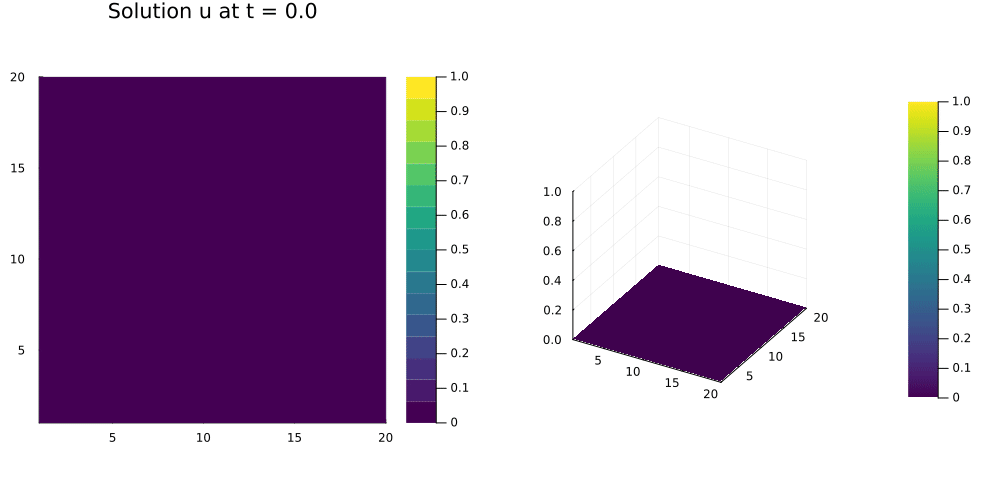

In [18]:
# Partie génération de GIF (si vous la voulez en plus, vous pouvez la décommenter) ---
println("Generating GIF...")
anim = @animate for i in 1:length(sol_result.t)
     t_current = sol_result.t[i]
     u_current = sol_result.u[i]
     myu2d_at_t = mypostprocess(u_current, dh, cvu, nels) # Assurez-vous que mypostprocess est définie
     title_str = "Solution u at t = $(round(t_current, digits=2))"
     p1 = Plots.contour(myu2d_at_t', fill=true, title=title_str, aspect_ratio=:equal, c=:viridis)
     p2 = Plots.surface(myu2d_at_t', title=" ", aspect_ratio=:equal, c=:viridis)
     Plots.plot(p1, p2, layout=(1,2), size=(1000, 500))
 end
 Plots.gif(anim, "transient_solution_penalty.gif", fps=10)
 println("GIF saved to transient_solution_penalty.gif")

try
    display("image/gif", read("transient_solution_penalty.gif"))
catch e
    println("Could not display GIF inline. Error: ", e)
    println("Please open 'transient_solution_penalty.gif' manually to view.")
end

## Section 4: Navier Stokes Equations

### Whole Model Problem Formulation

We consider a two-dimensional, time-dependent flow of a gas within the same cubic domain ($\Omega$) used in previous sections.

**Equation 1: Conservation of Mass (Continuity Equation)**
$$\nabla \cdot \mathbf{u} = 0$$
Where $\mathbf{u} = (u_x, u_z)$ is the velocity vector.

**Equation 2: Conservation of Momentum (Navier-Stokes Equations)**

* *x-momentum equation:*
    $$
    \rho_g \left( \frac{\partial u_x}{\partial t} + u_x \frac{\partial u_x}{\partial x} + u_z \frac{\partial u_x}{\partial z} \right) = -\frac{\partial p}{\partial x} + \mu \left( \frac{\partial^2 u_x}{\partial x^2} + \frac{\partial^2 u_x}{\partial z^2} \right) - S_x
    $$

* *z-momentum equation:*
    $$
    \rho_g\left( \frac{\partial u_z}{\partial t} + u_x \frac{\partial u_z}{\partial x} + u_z \frac{\partial u_z}{\partial z} \right) = -\frac{\partial p}{\partial z} + \mu \left( \frac{\partial^2 u_z}{\partial x^2} + \frac{\partial^2 u_z}{\partial z^2} \right) - S_z
    $$

Here:
* $u_x$ and $u_z$ are the velocity components in the x and z directions, respectively.
* $p$ is the pressure.
* $\rho_g$ is the constant gas density.
* $\mu$ is the constant dynamic viscosity of the gas.
* $S_r$ and $S_z$ represent the pressure loss in the bed due to viscous dissipation. $S_i$ in each direction is then calculated by:

$$S_i = \frac{\mu}{K}u_i$$, 

Where K denotes the permeability of the porous bed, $K=10^{-9} m^2$



This system is coupled (velocity and pressure are interdependent), non-linear (due to the convective terms $u_x \frac{\partial u_x}{\partial x}$, etc.), and time-dependent (due to the $\frac{\partial u}{\partial t}$ terms).

--- 

**Boundary Conditions:**

* **Left Patch (Inlet): Constant Total Pressure Condition**
    On the left boundary, we impose a constant **total pressure**, $P_{total}$. This introduces a non-linear velocity boundary condition, as total pressure is composed of static and dynamic components:
    $$
    P_{total} = P_{static} + P_{dynamic}
    $$
    Where:
    * $P_{static}$ will be set equal to the initial pressure inside the tank.
    * $P_{dynamic}$ is related to the kinetic energy of the fluid and is typically expressed as $\frac{1}{2}\rho_g |\mathbf{u}|^2$. This term directly introduces a non-linearity dependent on the fluid velocity at the inlet.

* **Top, Bottom, and Right Patches: No-Slip Conditions**
    On the top, bottom, and right boundaries, we apply **no-slip conditions**. This means the fluid velocity is fixed to zero at these walls:
    $$
    \quad u_x = 0, \quad u_z = 0
    $$

**Initial Conditions**

To start the transient simulation, we will define the initial state of the fluid:

* **Initial Velocity Field:**
    $$
    \mathbf{u}(\mathbf{x}, t=0) = \mathbf{0} \quad \text{everywhere in } \Omega
    $$
* **Initial Pressure Field:**
    $$
    p(\mathbf{x}, t=0) = P_{initial} \quad \text{everywhere in } \Omega
    $$
    Where $P_{initial}$ is a constant reference pressure within the domain.

### Comprehensive Solution Plan for Navier-Stokes Equations

Solving the incompressible Navier-Stokes equations, especially with non-linear boundary conditions and transient behavior, is a complex task. To tackle this effectively and robustly, we will employ a progressive, multi-phase numerical strategy. Each phase builds upon the previous one, leveraging its converged solution as an intelligent initial guess, which is crucial for the stability and efficiency of iterative non-linear solvers.

---

**Overall Strategy**

Our approach involves three distinct phases, moving from simplified steady-state problems to the full transient Navier-Stokes equations:

1.  **Steady-State Stokes Equations:**

Objective: To find the steady-state velocity $\mathbf{u}(\mathbf{x})$ and pressure $p(\mathbf{x})$ fields governed by the Stokes equations and use it as an initial guess for Steady-State Navier-Stokes Equations.

2.  **Steady-State Navier-Stokes Equations:**

Objective: To find the steady-state velocity $\mathbf{u}(\mathbf{x})$ and pressure $p(\mathbf{x})$ fields governed by the full Navier-Stokes equations and use it as an initial guess for Transient Navier-Stokes Equations.

3.  **Transient Navier-Stokes Equations:**
   
Objective: Simulating the full physical time evolution problem with non-linear boundary conditions.

--- 

For Phases 1 and 2, we will utilize a pseudo-transient approach with penalty ramping to robustly converge to the steady-state solution. For Phase 3, we will perform a true physical time integration. 
For each case, we consider a two-dimensional rectangular domain ($\Omega$) and the same BC and IC are applied. 


### 4.1 Steady-State Stokes Equations

#### 4.1.1 Model Problem  Formulation

* **Governing Equations:**

$$\nabla \cdot \mathbf{u} = 0$$

$$-\nabla p + \mu \nabla^2 \mathbf{u} - \mathbf{S} = \mathbf{0}$$

* **Boundary and Initial Conditions**

Same as in the "Whole Model Problem Formulation"

#### 4.1.2 Solution Approaches

**Detailed Phase Breakdown and Implementation Nuances**

* *Non-linearity:* In this phase, the only source of non-linearity is the total pressure boundary condition on the left patch ($P_{total} = P_{static} + \frac{1}{2}\rho_g |\mathbf{u}|^2$). The differential operators themselves are linear.

* *Solution Approach:* We will employ the pseudo-transient penalty ramping method using `DifferentialEquations.jl` like we did in **Section 3**.

    * An artificial time derivative $\rho_g \frac{\partial \mathbf{u}}{\partial t}$ will be introduced into the weak form of the momentum equations. This "time" $t$ is purely a numerical continuation parameter, not physical time.

    * The penalty parameter ($p_{penalty}$) associated with the non-linear total pressure boundary condition will be ramped up with this artificial time, $p_{penalty}(t) = t$. This gradual increase helps the non-linear solver (Newton's method) to converge robustly from an initial guess far from the solution.
 
* *Initial Guess* for Pseudo-Transient Solver: Typically, zero velocity and a constant initial pressure field ($\mathbf{u}(\mathbf{x}, t=0) = \mathbf{0}$, $p(\mathbf{x}, t=0) = P_{initial}$) will be used.

* `solve` call parameters:
    * `tspan = (0.0, T_{large})`: A sufficiently large artificial time span to ensure convergence.

    * `callback`: A `SteadyStateCallback` will be used to automatically terminate the simulation once the solution has converged to a steady state (i.e., when the norm of the artificial time derivative becomes sufficiently small).

* *Output:* A converged steady-state solution for Stokes equations: $(\mathbf{u}_{Stokes, steady}, p_{Stokes, steady})$.

#### 4.1.3 Numerical Solution

### 4.2 Steady-State Navier Stokes Equations

#### 4.2.1 Model Problem Formulation

* **Governing Equations:**
  
$$\nabla \cdot \mathbf{u} = 0$$
$$\rho_g (\mathbf{u} \cdot \nabla) \mathbf{u} = -\nabla p + \mu \nabla^2 \mathbf{u} + \mathbf{S}$$

* **Boundary and Initial Conditions**

Same as in the "Whole Model Problem Formulation"

#### 4.2.2 Solution Approaches


**Detailed Phase Breakdown and Implementation Nuances**

* *Non-linearity:* This phase introduces two sources of non-linearity:
  
    1.  The convective terms ($\rho_g (\mathbf{u} \cdot \nabla) \mathbf{u}$).
  
    2.  The total pressure boundary condition on the left patch.
 
* *Solution Approach*: We will continue to use the *pseudo-transient penalty ramping method* with `DifferentialEquations.jl`.

    * The same artificial time derivative $\rho_g \frac{\partial \mathbf{u}}{\partial t}$ will be included in the weak form. The "time" $t$ remains a numerical continuation parameter.
  
    * The penalty parameter for the left patch boundary condition will still be ramped up with this artificial time ($p_{penalty}(t) = t$). This helps manage the combined non-linearities.
 
* *Initial Guess for Pseudo-Transient Solver:* The converged steady-state solution from **Section 4.1**, will serve as the initial guess for this phase. This provides a physically plausible starting point, greatly aiding the convergence of the non-linear solver for the full Navier-Stokes equations.

* `solve` call parameters:

    * `tspan = (0.0, T_{large})`: A sufficiently large artificial time span.
  
    * `callback`: A `SteadyStateCallback` will be used to stop when convergence to steady state is achieved.
 
* *Output:* A converged steady-state solution for Navier-Stokes equations: $(\mathbf{u}_{NS, steady}, p_{NS, steady})$.

### 4.3 Transient Navier Stokes Equations

#### 4.3.1 Model Problem Formulation

* **Governing Equations:**

$$\nabla \cdot \mathbf{u} = 0$$

$$\rho_g \frac{\partial \mathbf{u}}{\partial t} + \rho_g (\mathbf{u} \cdot \nabla) \mathbf{u} = -\nabla p + \mu \nabla^2 \mathbf{u} + \mathbf{S}$$

* **Boundary and Initial Conditions**

Same as in the "Whole Model Problem Formulation"

**Detailed Phase Breakdown and Implementation Nuances**

* *Non-linearity:* Both the convective terms and the total pressure boundary condition remain non-linear.
  
* *Solution Approach:* We will use `DifferentialEquations.jl` for physical time integration.

    * The time derivative $\rho_g \frac{\partial \mathbf{u}}{\partial t}$ is now the physical inertia term. The "time" $t$ represents real physical time.
  
    * The penalty parameter for the left patch boundary condition will be fixed at a high, constant value. This is because the initial condition for this phase already satisfies the boundary condition (as it came from a converged steady-state solution where the penalty was ramped up), and we want the boundary condition to be strongly enforced throughout the physical simulation.

* *Initial Condition for Physical Transient Solver:* The converged steady-state solution from **Section 4.2**, $(\mathbf{u}_{NS, steady}, p_{NS, steady})$, will be used as the initial condition for this physical transient simulation. Starting from a stable, physically consistent state is crucial for observing the true dynamic behavior.

* *`solve` call parameters:*
    * `tspan = (0.0, T_{physical})`: The actual physical duration of the simulation.
      
    * `callback`: No `SteadyStateCallback` is used, as we are interested in the time evolution, not just convergence to a steady state.
 
    * `saveat`: This parameter will be used to save the solution at regular physical time intervals for animation and post-processing.
      
* *Output:* The time-dependent velocity and pressure fields: $\mathbf{u}(\mathbf{x}, t)$ and $p(\mathbf{x}, t)$.